# Advanced Macroeconomics 1: Homework 2

## Settings

In [1]:
######################################################
# 📦 Package Imports
######################################################

### Data manipulation ###
import pandas as pd  # DataFrame handling
import numpy as np  # Numerical operations
import random  # For reproducibility

### Visualization ###
import matplotlib.pyplot as plt  # General plotting
import seaborn as sns  # Statistical data visualization

### Time Series & Statistical Models ###
import statsmodels.api as sm  # Statistical models
from statsmodels.tsa.stattools import (
    adfuller,  # Augmented Dickey-Fuller Test
    kpss,      # KPSS Test
    acf, pacf  # Autocorrelation functions
)
from statsmodels.tsa.arima.model import ARIMA  # ARIMA model
from statsmodels.graphics.tsaplots import (
    plot_acf,  # ACF plot
    plot_pacf  # PACF plot
)
from statsmodels.stats.diagnostic import acorr_ljungbox  # Ljung-Box test

from arch.unitroot import PhillipsPerron, ZivotAndrews  # PP and Zivot-Andrews tests

### Machine Learning Metrics ###
from sklearn.metrics import mean_squared_error  # Evaluation metric

### Extra ###
import warnings
warnings.filterwarnings("ignore")

### External Data Sources (optional) ###
import ipeadatapy as ipea  # For accessing IPEA data (if needed)

# Set seed for reproducibility
seed = 42
np.random.seed(seed)
random.seed(seed)


In [2]:
rgb_color = (162 / 255, 37 / 255, 56 / 255)  # Red

In [3]:
warnings.filterwarnings("ignore")

## Questions

### Question 1

Using the time series provided in the course drive (in `.txt`, `.csv`, and `.xls` formats), perform unit root tests and verify the stationarity of each series. Indicate whether each series is stationary or not.

Apply the following tests:
- Augmented Dickey-Fuller (ADF)
- Phillips-Perron (PP)
- Kwiatkowski–Phillips–Schmidt–Shin (KPSS)
- Zivot-Andrews test for structural breaks
- Any other relevant tests you consider necessary

Include your code in the appendix. Be prepared to explain your results and code if asked.

#### Data

In [4]:
# Load the data
file_path = r"data_exercicio.csv"
df = pd.read_csv(file_path)

# Set index to a RangeIndex
df.index = pd.RangeIndex(start=0, stop=len(df), step=1)

#### Plot the series

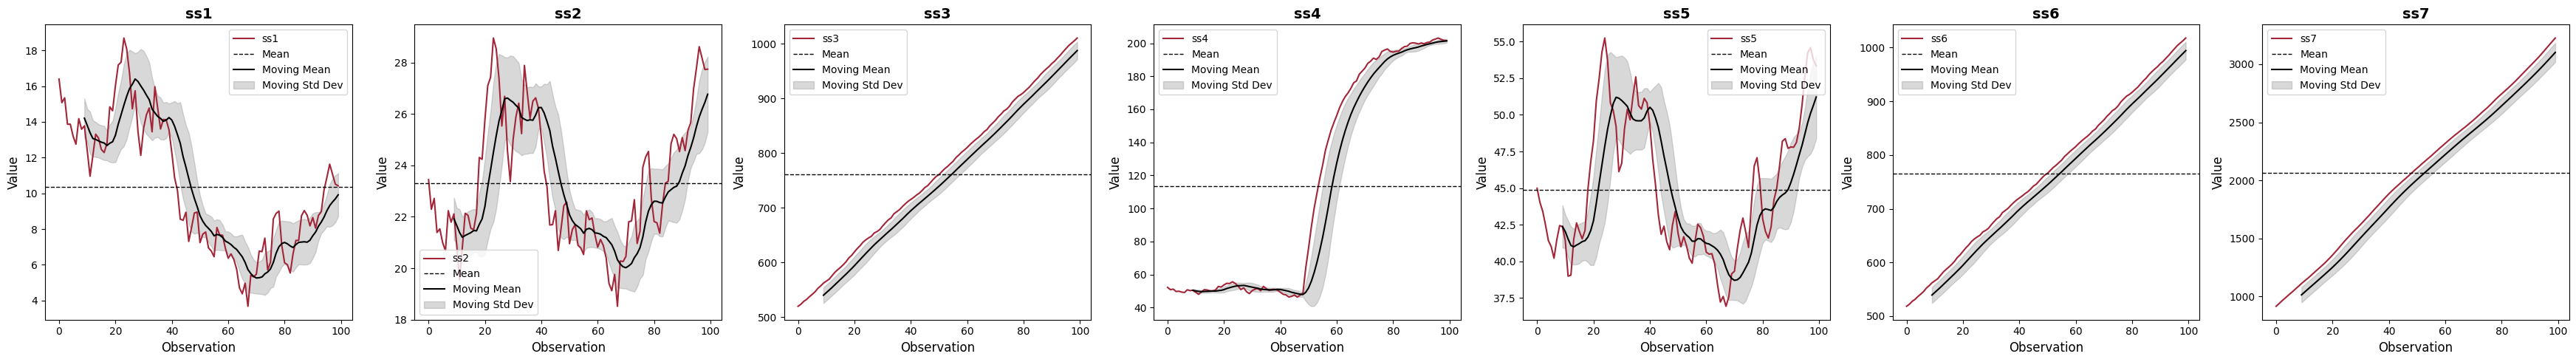

In [5]:
# Define the columns of the original series (assuming they are the first 4)
series_columns = 'ss1', 'ss2', 'ss3', 'ss4', 'ss5', 'ss6', 'ss7'

# Set the window size for the moving average and moving standard deviation
window_size = 10



# Create side-by-side subplots (1 row, one column for each series)
fig, axes = plt.subplots(1, len(series_columns), figsize=(5 * len(series_columns), 5), sharex=True)

# If there is only one series, wrap the axis in a list to maintain the loop
if len(series_columns) == 1:
    axes = [axes]

# Loop to generate the plot for each series
for ax, column in zip(axes, series_columns):
    # Calculate the moving average and moving standard deviation locally
    moving_mean = df[column].rolling(window=window_size).mean()
    moving_std = df[column].rolling(window=window_size).std()
    
    # Calculate the overall mean of the original series
    mean_value = df[column].mean()
    
    # Plot the original series
    ax.plot(df.index, df[column], label=column, color = rgb_color ,linewidth=1.5)
    
    # Draw a horizontal line indicating the mean
    ax.axhline(mean_value, color='black', linestyle='--', linewidth=1, label='Mean')
    
    # Plot the moving average
    ax.plot(df.index, moving_mean, color='black', linewidth=1.5, linestyle='-', label='Moving Mean')
    
    # Plot the moving standard deviation band
    ax.fill_between(df.index, moving_mean - moving_std, moving_mean + moving_std, 
                    color='grey', alpha=0.3, label='Moving Std Dev')
    
    # Remove background and extra borders using the current subplot (ax)
    ax.set_facecolor('white')         # Remove background color
    
    # Set title, labels, and grid
    ax.set_title(column, fontsize=14, fontweight='bold')
    ax.set_xlabel("Observation", fontsize=12)
    ax.set_ylabel("Value", fontsize=12)
    ax.legend()
    ax.grid(False)

plt.tight_layout()
plt.show()


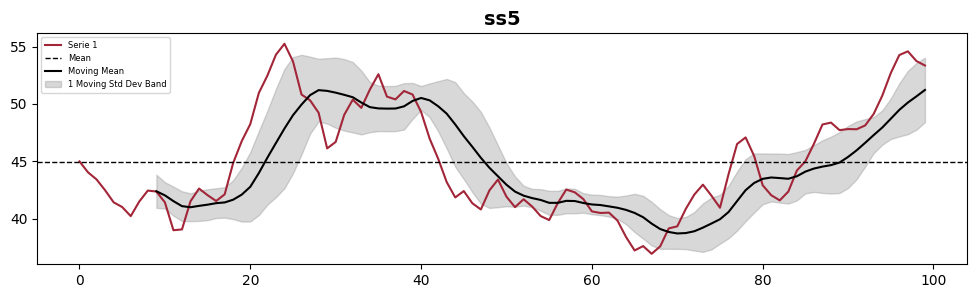

In [6]:
# Graph for specific serie
column = "ss5"

# Define the moving window size
window_size = 10

# Calculate moving average and moving standard deviation
df['Moving_Mean'] = df[column].rolling(window=window_size).mean() # Not using
df['Moving_Std'] = df[column].rolling(window=window_size).std()

# Calculate mean and standard deviation
mean_value = df[column].mean()
std_dev = df[column].std()

# Create the plot
plt.figure(figsize=(12, 3))
plt.plot(df.index, df[column], color=rgb_color, linewidth=1.5, label="Serie 1")
plt.axhline(mean_value, color='black', linestyle='--', linewidth=1, label='Mean')  # Dotted line for mean

# Plot standard deviation bands
#plt.fill_between(df.index, mean_value - std_dev, mean_value + std_dev, color='gray', alpha=0.3, label='1 Std Dev Band')

# Plot moving average
plt.plot(df.index, df['Moving_Mean'], color='black', linewidth=1.5, linestyle='-', label="Moving Mean")

# Plot moving standard deviation bands
plt.fill_between(df.index, 
                 df['Moving_Mean'] - df['Moving_Std'], 
                 df['Moving_Mean'] + df['Moving_Std'], 
                 color='grey', alpha=0.3, label='1 Moving Std Dev Band')

# Add titles and labels
plt.title(column, fontsize=14, fontweight='bold')
plt.xlabel('', fontsize=12)
plt.ylabel('', fontsize=14)
plt.legend(fontsize = 6)
plt.show()

#### Stationarity Analysis of Time Series

In [7]:
def stationarity_tests_verbose(series, name):
    results = {}

    # ADF (Augmented Dickey-Fuller)
    try:
        adf_p = adfuller(series.dropna(), autolag='AIC')[1]
        results['ADF'] = (
            "stationary (unit root rejected)" if adf_p < 0.05
            else "non-stationary (unit root not rejected)"
        )
    except:
        results['ADF'] = "error"

    # DF (Dickey-Fuller classic)
    try:
        df_p = adfuller(series.dropna(), maxlag=0, regression='c')[1]
        results['DF'] = (
            "stationary (unit root rejected)" if df_p < 0.05
            else "non-stationary(unit root not rejected)"
        )
    except:
        results['DF'] = "error"

    # PP
    try:
        pp_p = PhillipsPerron(series.dropna()).pvalue
        results['PP'] = (
            "stationary (unit root rejected)" if pp_p < 0.05
            else "non-stationary (unit root not rejected)"
        )
    except:
        results['PP'] = "error"

    # KPSS
    try:
        kpss_p = kpss(series.dropna(), regression='c', nlags='auto')[1]
        results['KPSS'] = (
            "stationary (null of stationarity not rejected)" if kpss_p > 0.05
            else "non-stationary (null of stationarity rejected)"
        )
    except:
        results['KPSS'] = "error"

    # Zivot-Andrews
    try:
        za_p = ZivotAndrews(series.dropna()).pvalue
        results['Zivot-Andrews'] = (
            "stationary with structural break (unit root rejected)" if za_p < 0.05
            else "non-stationary (unit root not rejected)"
        )
    except:
        results['Zivot-Andrews'] = "error"

    return pd.Series(results, name=name)



In [30]:
series_names = ['ss1', 'ss2', 'ss3', 'ss4', 'ss5', 'ss6', 'ss7']

results_df = pd.DataFrame()

for col in series_names:
    results_df = pd.concat([results_df, stationarity_tests_verbose(df[col], col)], axis=1)

for col in series_names:
    print(f"Results for {col}")
    print(stationarity_tests_verbose(df[col], col))
    print("\n" + "-"*50 + "\n")

Results for ss1
ADF                     non-stationary (unit root not rejected)
DF                      non-stationary (unit root not rejected)
PP                      non-stationary (unit root not rejected)
KPSS             non-stationary (null of stationarity rejected)
Zivot-Andrews           non-stationary (unit root not rejected)
Name: ss1, dtype: object

--------------------------------------------------

Results for ss2
ADF                     non-stationary (unit root not rejected)
DF                      non-stationary (unit root not rejected)
PP                      non-stationary (unit root not rejected)
KPSS             stationary (null of stationarity not rejected)
Zivot-Andrews           non-stationary (unit root not rejected)
Name: ss2, dtype: object

--------------------------------------------------

Results for ss3
ADF                     non-stationary (unit root not rejected)
DF                      non-stationary (unit root not rejected)
PP                      non-

### Question 2

Using the time series obtained from the IPEADATA website, apply unit root tests to the following variables:

- Gross Domestic Product (GDP) at market prices: chained volume index (base year 1995 = 100)
- IPCA - General Price Index (base December 1993 = 100)

Determine whether each series is stationary or not.

Apply the following tests:
- Augmented Dickey-Fuller (ADF)
- Phillips-Perron (PP)
- Kwiatkowski–Phillips–Schmidt–Shin (KPSS)
- Zivot-Andrews test for structural breaks
- Any other relevant tests you consider necessary

Include your code in the appendix. Be prepared to explain your results and interpretations if asked.

#### Data

In [33]:
# Here we use a keyword to search for available time series or browse them manually on the IPEA website
ipea.metadata()

# GDP series
ipea.describe('SCN104_PIBPM104')

,PIB - preços de mercado - índice real encadeado (média 1995 = 100)
Name,PIB - preços de mercado - índice real encadead...
Code,SCN104_PIBPM104
Big Theme,Macroeconômico
Theme code,8
Source,Instituto Brasileiro de Geografia e Estatístic...
Source acronym,IBGE/SCN Trim.
Comment,O produto interno bruto (PIB) é o total dos be...
Last update,2025-03-07T13:32:00.727-03:00
Frequency,Trimestral
Measure,-


In [34]:
# IPCA series
ipea.describe('PRECOS12_IPCA12')

,IPCA - geral - índice (dez. 1993 = 100)
Name,IPCA - geral - índice (dez. 1993 = 100)
Code,PRECOS12_IPCA12
Big Theme,Macroeconômico
Theme code,9
Source,Instituto Brasileiro de Geografia e Estatístic...
Source acronym,IBGE/SNIPC
Comment,O Índice Nacional de Preços ao Consumidor Ampl...
Last update,2025-03-12T16:26:01.02-03:00
Frequency,Mensal
Measure,-


#### Plot the series

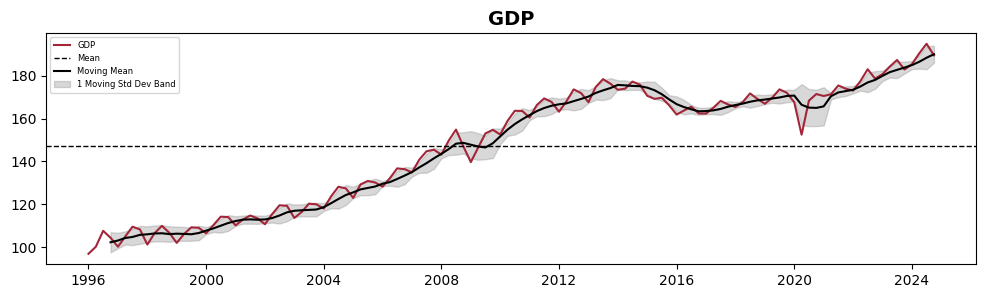

In [35]:
gdp = ipea.timeseries('SCN104_PIBPM104')

gdp = gdp.rename(columns={
    'RAW DATE': 'date',
    'VALUE (-)': 'GDP',
    'CODE': 'code',
    'DAY': 'day',
    'MONTH': 'month',
    'YEAR': 'year'
})
################ Plot ################

column = "GDP"

# Define the moving window size
window_size = 4

# Calculate moving average and moving standard deviation
gdp['Moving_Mean'] = gdp[column].rolling(window=window_size).mean()
gdp['Moving_Std'] = gdp[column].rolling(window=window_size).std()

# Calculate mean and standard deviation
mean_value = gdp[column].mean()
std_dev = gdp[column].std()

# Create the plot
plt.figure(figsize=(12, 3))
plt.plot(gdp.index, gdp[column], color=rgb_color, linewidth=1.5, label="GDP")
plt.axhline(mean_value, color='black', linestyle='--', linewidth=1, label='Mean')  # Dotted line for mean

# Plot standard deviation bands
#plt.fill_between(gdp.index, mean_value - std_dev, mean_value + std_dev, color='gray', alpha=0.3, label='1 Std Dev Band')

# Plot moving average
plt.plot(gdp.index, gdp['Moving_Mean'], color='black', linewidth=1.5, linestyle='-', label="Moving Mean")

# Plot moving standard deviation bands
plt.fill_between(gdp.index, 
                 gdp['Moving_Mean'] - gdp['Moving_Std'], 
                 gdp['Moving_Mean'] + gdp['Moving_Std'], 
                 color='grey', alpha=0.3, label='1 Moving Std Dev Band')

# Add titles and labels
plt.title(column, fontsize=14, fontweight='bold')
plt.xlabel('', fontsize=12)
plt.ylabel('', fontsize=14)
plt.legend(fontsize = 6)
plt.show()


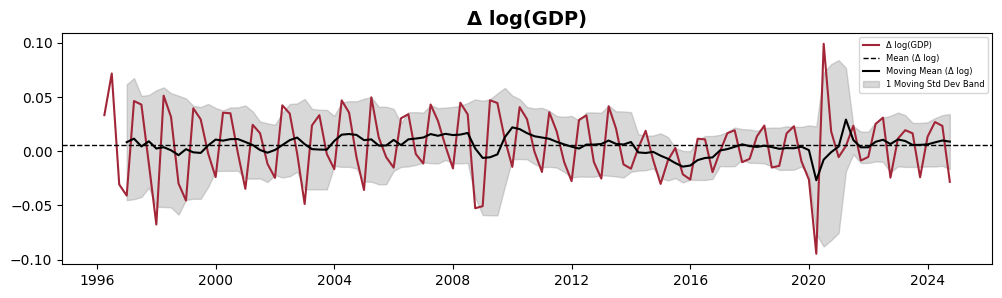

In [36]:
gdp = ipea.timeseries('SCN104_PIBPM104')

gdp = gdp.rename(columns={
    'RAW DATE': 'date',
    'VALUE (-)': 'GDP',
    'CODE': 'code',
    'DAY': 'day',
    'MONTH': 'month',
    'YEAR': 'year'
})

################ Plot Growth Rate ################
# ------ Difference of logs over time represents the growth rate ------

column = "GDP"

# Apply log transformation to the GDP column
gdp['Log_GDP'] = np.log(gdp[column])

# Calculate the first difference of the log
gdp['Log_Diff'] = gdp['Log_GDP'].diff()

# Define the moving window size
window_size = 4

# Calculate moving average and moving standard deviation of the differenced log series
gdp['Moving_Mean'] = gdp['Log_Diff'].rolling(window=window_size).mean()
gdp['Moving_Std'] = gdp['Log_Diff'].rolling(window=window_size).std()

# Calculate overall mean and standard deviation of the differenced log series
mean_value = gdp['Log_Diff'].mean()
std_dev = gdp['Log_Diff'].std()

# Create the plot
plt.figure(figsize=(12, 3))

# Plot the differenced log series
plt.plot(gdp.index, gdp['Log_Diff'], color=rgb_color, linewidth=1.5, label="Δ log(GDP)")

# Horizontal line for the overall mean
plt.axhline(mean_value, color='black', linestyle='--', linewidth=1, label='Mean (Δ log)')

# Plot the moving average
plt.plot(gdp.index, gdp['Moving_Mean'], color='black', linewidth=1.5, linestyle='-', label="Moving Mean (Δ log)")

# Plot the moving standard deviation band
plt.fill_between(gdp.index, 
                 gdp['Moving_Mean'] - gdp['Moving_Std'], 
                 gdp['Moving_Mean'] + gdp['Moving_Std'], 
                 color='grey', alpha=0.3, label='1 Moving Std Dev Band')

# Add title and legend
plt.title('Δ log(' + column + ')', fontsize=14, fontweight='bold')
plt.xlabel('', fontsize=12)
plt.ylabel('', fontsize=14)
plt.legend(fontsize=6)
plt.show()

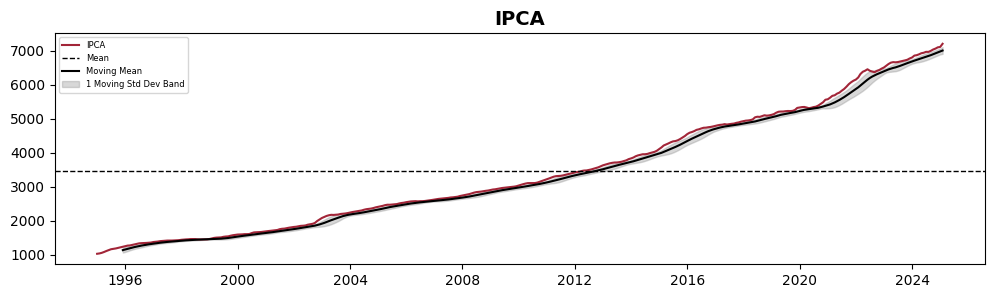

In [37]:
ipca = ipea.timeseries('PRECOS12_IPCA12')

ipca = ipca.rename(columns={
    'RAW DATE': 'date',
    'VALUE (-)': 'IPCA',
    'CODE': 'code',
    'DAY': 'day',
    'MONTH': 'month',
    'YEAR': 'year'
})
################ Plot ################


column = "IPCA"

ipca = ipca[ipca.index >= '1995-01-01']

# Define the moving window size
window_size = 12

# Calculate moving average and moving standard deviation
ipca['Moving_Mean'] = ipca[column].rolling(window=window_size).mean()
ipca['Moving_Std'] = ipca[column].rolling(window=window_size).std()

# Calculate mean and standard deviation
mean_value = ipca[column].mean()
std_dev = ipca[column].std()

# Create the plot
plt.figure(figsize=(12, 3))
plt.plot(ipca.index, ipca[column], color=rgb_color, linewidth=1.5, label="IPCA")
plt.axhline(mean_value, color='black', linestyle='--', linewidth=1, label='Mean')  # Dotted line for mean

# Plot standard deviation bands
#plt.fill_between(ipca.index, mean_value - std_dev, mean_value + std_dev, color='gray', alpha=0.3, label='1 Std Dev Band')

# Plot moving average
plt.plot(ipca.index, ipca['Moving_Mean'], color='black', linewidth=1.5, linestyle='-', label="Moving Mean")

# Plot moving standard deviation bands
plt.fill_between(ipca.index, 
                 ipca['Moving_Mean'] - ipca['Moving_Std'], 
                 ipca['Moving_Mean'] + ipca['Moving_Std'], 
                 color='grey', alpha=0.3, label='1 Moving Std Dev Band')

# Add titles and labels
plt.title(column, fontsize=14, fontweight='bold')
plt.xlabel('', fontsize=12)
plt.ylabel('', fontsize=14)
plt.legend(fontsize = 6)
plt.show()

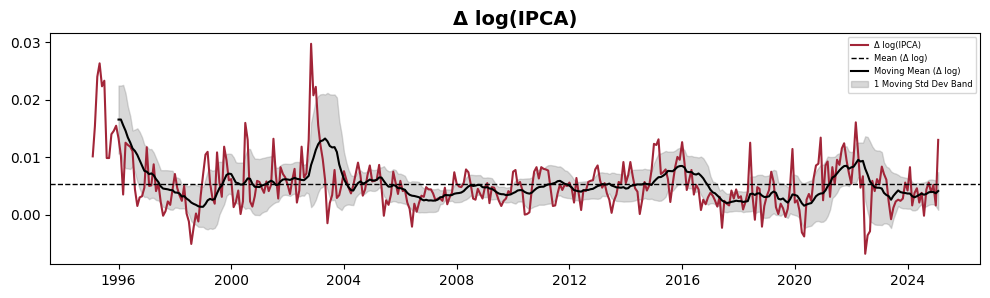

In [38]:
ipca = ipea.timeseries('PRECOS12_IPCA12')

ipca = ipca.rename(columns={
    'RAW DATE': 'date',
    'VALUE (-)': 'IPCA',
    'CODE': 'code',
    'DAY': 'day',
    'MONTH': 'month',
    'YEAR': 'year'
})

################ Plot Growth Rate ################
# ------ Difference of logs over time represents the growth rate ------

column = "IPCA"

# Filter the data from 1995 onwards
ipca = ipca[ipca.index >= '1995-01-01'].copy()

# Apply log transformation to the IPCA column
ipca['Log_IPCA'] = np.log(ipca[column])

# Calculate the first difference of the log
ipca['Log_Diff'] = ipca['Log_IPCA'].diff()

# Define the moving window size
window_size = 12

# Calculate moving average and moving standard deviation of the differenced log series
ipca['Moving_Mean'] = ipca['Log_Diff'].rolling(window=window_size).mean()
ipca['Moving_Std'] = ipca['Log_Diff'].rolling(window=window_size).std()

# Calculate overall mean and standard deviation of the differenced log series
mean_value = ipca['Log_Diff'].mean()
std_dev = ipca['Log_Diff'].std()

# Create the plot
plt.figure(figsize=(12, 3))

# Plot the differenced log series
plt.plot(ipca.index, ipca['Log_Diff'], color=rgb_color, linewidth=1.5, label="Δ log(IPCA)")

# Horizontal line for the overall mean
plt.axhline(mean_value, color='black', linestyle='--', linewidth=1, label='Mean (Δ log)')

# Plot the moving average
plt.plot(ipca.index, ipca['Moving_Mean'], color='black', linewidth=1.5, linestyle='-', label="Moving Mean (Δ log)")

# Plot the moving standard deviation band
plt.fill_between(ipca.index, 
                 ipca['Moving_Mean'] - ipca['Moving_Std'], 
                 ipca['Moving_Mean'] + ipca['Moving_Std'], 
                 color='grey', alpha=0.3, label='1 Moving Std Dev Band')

# Add title and legend
plt.title('Δ log(' + column + ')', fontsize=14, fontweight='bold')
plt.xlabel('', fontsize=12)
plt.ylabel('', fontsize=14)
plt.legend(fontsize=6)
plt.show()

#### Stationarity Analysis of Time Series

In [39]:
def stationarity_tests_verbose(series, name):
    results = {}

    # ADF (Augmented Dickey-Fuller)
    try:
        adf_p = adfuller(series.dropna(), autolag='AIC')[1]
        results['ADF'] = (
            "stationary (unit root rejected)" if adf_p < 0.05
            else "non-stationary (unit root not rejected)"
        )
    except:
        results['ADF'] = "error"

    # DF (Dickey-Fuller classic)
    try:
        df_p = adfuller(series.dropna(), maxlag=0, regression='c')[1]
        results['DF'] = (
            "stationary (unit root rejected)" if df_p < 0.05
            else "non-stationary (unit root not rejected)"
        )
    except:
        results['DF'] = "error"

    # PP
    try:
        pp_p = PhillipsPerron(series.dropna()).pvalue
        results['PP'] = (
            "stationary (unit root rejected)" if pp_p < 0.05
            else "non-stationary (unit root not rejected)"
        )
    except:
        results['PP'] = "error"

    # KPSS
    try:
        kpss_p = kpss(series.dropna(), regression='c', nlags='auto')[1]
        results['KPSS'] = (
            "stationary (null of stationarity not rejected)" if kpss_p > 0.05
            else "non-stationary (null of stationarity rejected)"
        )
    except:
        results['KPSS'] = "error"

    # Zivot-Andrews
    try:
        za_p = ZivotAndrews(series.dropna()).pvalue
        results['Zivot-Andrews'] = (
            "stationary with structural break (unit root rejected)" if za_p < 0.05
            else "non-stationary (unit root not rejected)"
        )
    except:
        results['Zivot-Andrews'] = "error"

    return pd.Series(results, name=name)



In [42]:
# Run tests on GDP and Log_GDP
gdp_result = stationarity_tests_verbose(gdp['GDP'], name='GDP')
log_gdp_result = stationarity_tests_verbose(gdp['Log_GDP'], name='Log_GDP')

# Run tests on IPCA and Log_IPCA
ipca_result = stationarity_tests_verbose(ipca['IPCA'], name='IPCA')
log_ipca_result = stationarity_tests_verbose(ipca['Log_IPCA'], name='Log_IPCA')

# Exibir como texto, limpo para PDF
for name, result in [('GDP', gdp_result), 
                     ('Log_GDP', log_gdp_result), 
                     ('IPCA', ipca_result), 
                     ('Log_IPCA', log_ipca_result)]:
    print(f"Stationarity Test Results for {name}")
    print(result)
    print("\n" + "-"*60 + "\n")

Stationarity Test Results for GDP
ADF                     non-stationary (unit root not rejected)
DF                      non-stationary (unit root not rejected)
PP                      non-stationary (unit root not rejected)
KPSS             non-stationary (null of stationarity rejected)
Zivot-Andrews           non-stationary (unit root not rejected)
Name: GDP, dtype: object

------------------------------------------------------------

Stationarity Test Results for Log_GDP
ADF                     non-stationary (unit root not rejected)
DF                      non-stationary (unit root not rejected)
PP                      non-stationary (unit root not rejected)
KPSS             non-stationary (null of stationarity rejected)
Zivot-Andrews           non-stationary (unit root not rejected)
Name: Log_GDP, dtype: object

------------------------------------------------------------

Stationarity Test Results for IPCA
ADF                     non-stationary (unit root not rejected)
DF       